# Recherche de décalage entre deux images : tests avec la tranformée en ondelettes

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib.pyplot import figure
import matplotlib.patches as patches

from scipy import signal
from scipy import misc

import cv2

import warnings
warnings.filterwarnings("ignore")

import pywt
import pywt.data

### Chargement des deux images - relevé topo / image satellite

In [8]:
band1 = np.loadtxt("band1.txt")
band2 = np.loadtxt("band2.txt")

### Transformée en ondelettes du relevé topographique

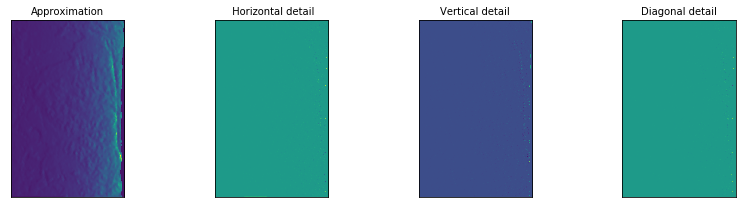

In [9]:
# Load image
original = band1

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest")
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

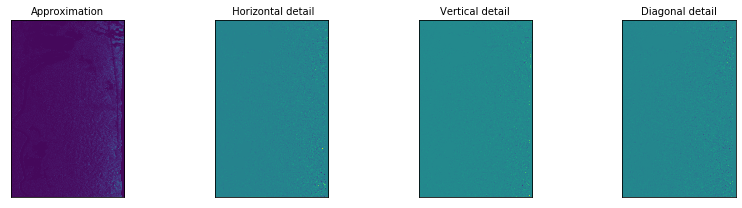

In [10]:
# Load image
original = band2

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest")
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [11]:
bandr1 = np.copy(band1[750:1750,400:1000])
bandr2 = np.copy(band2[750:1750,400:1000])

In [12]:
LL1,(LH1,HL1,HH1) = pywt.dwt2(np.copy(band1[750:1750,400:1000]),'bior1.3')
LL2,(LH2,HL2,HH2) = pywt.dwt2(np.copy(band2[750:1750,400:1000]),'bior1.3')

In [13]:
def decalageBloc(original, template):
    orig = np.copy(original)  #prévenir pbs de pointeurs python
    temp = np.copy(template)

    orig -= original.mean()
    orig = orig/np.std(orig)
    temp -= template.mean()
    temp = temp/np.std(temp)

    corr = signal.correlate2d(orig, temp, boundary='symm', mode='same')
    y, x = np.unravel_index(np.argmax(corr), corr.shape)  # find the match
    
    return orig, temp, corr, x, y

def displayImg(original,template,corr,x,y):
    n,m = np.shape(original)
    fig, (ax_orig, ax_template, ax_corr) = plt.subplots(1, 3,figsize=(10, 20))
    ax_orig.imshow(original)
    ax_orig.set_title('Original')
    
    ax_template.imshow(template)
    ax_template.set_title('Template')
    
    ax_corr.imshow(corr)
    ax_corr.set_title('Cross-correlation')
    
    ax_orig.plot(x, y, 'ro')
    ax_orig.plot(n/2,n/2, 'rx')
    #ax_template.plot(x, y, 'ro')
    fig.show()
    
    print("(x,y) = ("+str(x)+','+str(y)+')' )

#     figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
#     plt.imshow(original)
#     plt.plot(x, y, 'ro')

def gaussianFilter(im1,factor):
    kernel = np.ones((factor,factor),np.float32)/(factor**2)
    target = cv2.filter2D(im1,-1,kernel)
    return target

def sharpenFilter(im):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(im, -1, kernel)
    return im


def sharpenFilter2(im):
    kernel = np.array([[1,0,-1], [0,0,0], [-1,0,1]])
    im = cv2.filter2D(im, -1, kernel)
    return im

def selection(img,x0,x1,y0,y1):
    h = abs(x0 - x1)
    w = abs(y0 - y1)
    fig,ax = plt.subplots(1, 2,figsize=(16, 8))
    im1 = ax[0].imshow(img)
    rect = patches.Rectangle((y0,x0),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title("Image originale")
    fig.colorbar(im1,ax=ax[0])
    im2 = ax[1].imshow(img[x0:x0+h,y0:y0+w])
    ax[1].set_title("Selection")
    fig.colorbar(im2,ax=ax[1])

    plt.show()
    return img[x0:x0+h,y0:y0+w]

- Bloc 200*200 : on essaie de faire argmax de qqch de vide 

(x,y) = (193,238)
(x,y) = (0,0)


ValueError: attempt to get argmax of an empty sequence

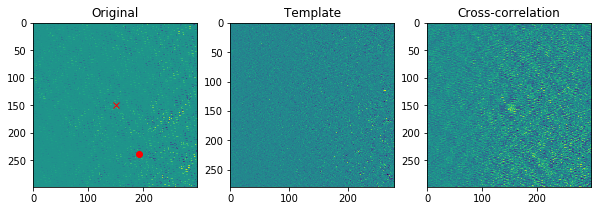

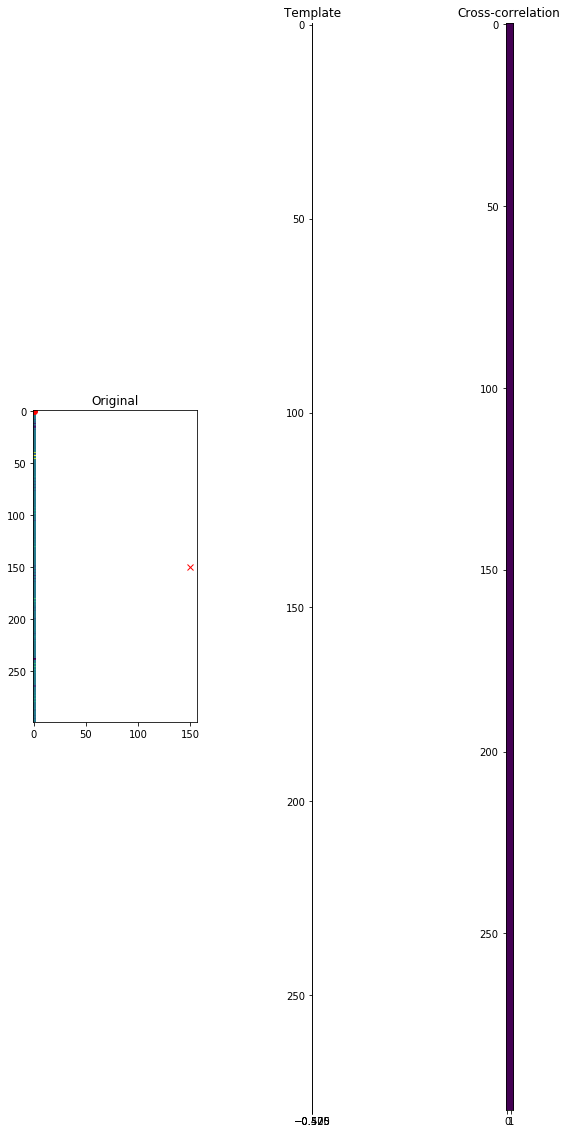

In [16]:
def decalageImg(bandr2,bandr1):
    tabx = []
    taby = []
        
    for i in range(3):
        for j in range(3):
            band2Block = np.copy(bandr2[i*300:(i*300)+299,j*300:(j*300)+299])
            band1Block = np.copy(bandr1[i*300:(i*300)+299,j*300:(j*300)+299])
            templateBlock = np.copy(band1Block[10:290,10:290])
                        
            orig,temp,corr,x,y = decalageBloc(band2Block,templateBlock)
            displayImg(orig,temp,corr,x,y)
            xm = x-100
            ym = y-100
            tabx.append(xm)
            taby.append(ym)
    return tabx,taby

# # tabx,taby = decalageImg(gaussianFilter(bandr2,4),bandr1)
# rez = []
# for i in range(1,5):

tabx,taby = decalageImg(LH1,LH2)


#tabx,taby = decalageImg(gaussianFilter(bandr2,5),gaussianFilter(bandr1,2))
#rez.append(countCorrect(tabx,taby,20)[1])
 
# plt.plot(rez)
# plt.show()